In [1]:
%load_ext autoreload
%autoreload 2
import seaborn as sns 
sns.set_theme()

Shape of paths:  torch.Size([10000, 61, 2])
Shape of information:  torch.Size([10000, 61, 2])


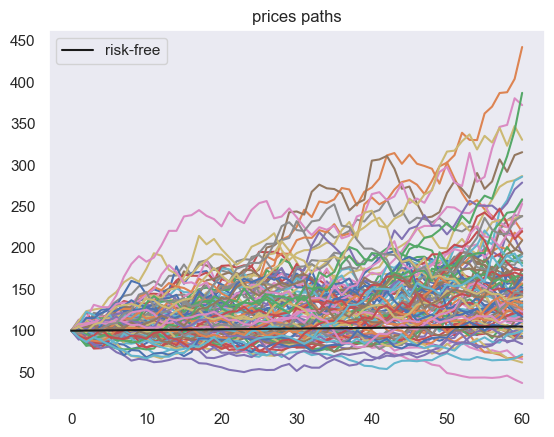

In [2]:
from neuralhedge.data.market import BS_Market
from neuralhedge.utils.plotting import plot_manage_ds
bs_market = BS_Market(n_timestep=60, dt=1/12, r=0.01)
ds_train = bs_market.get_manage_ds()
plot_manage_ds(ds_train)

In [3]:
from collections import defaultdict
from neuralhedge.nn.loss import log_utility
from neuralhedge.utils.evaluation import evaluate_mv
import numpy as np
import matplotlib.pyplot as plt

In [4]:
from neuralhedge.nn.blackschole import BlackScholesAlpha, BlackScholesMeanVarianceAlpha, BlackScholesMeanVarianceAlphaClip
from neuralhedge.nn.datamanager import WealthManager
def efficient_frontier(sigma, strategy_name):
    bs_market = BS_Market(n_timestep=60, dt=1/12, r=0.01, sigma = sigma)
    ds_test = bs_market.get_manage_ds()
    if strategy_name == 'constant':
        constant_mean_var = defaultdict(list)
        for alpha in np.linspace(0, 1, 101):
            constant_strategy = BlackScholesAlpha(mu=bs_market.mu, sigma = bs_market.sigma, r=bs_market.r,alpha = alpha)
            constant_manager = WealthManager(constant_strategy, utility_func=log_utility)
            mean, var = evaluate_mv(constant_manager,ds_test)
            constant_mean_var['mean'].append(mean)
            constant_mean_var['var'].append(var)
        return constant_mean_var
    elif strategy_name == 'optimal':
        optimal_mean_var = defaultdict(list)
        for Wstar in np.linspace(1, 4, 101):
            optimal_strategy = BlackScholesMeanVarianceAlpha(mu=bs_market.mu, sigma = bs_market.sigma, r=bs_market.r,Wstar=Wstar)
            optimal_manager = WealthManager(optimal_strategy, utility_func=log_utility)
            mean, var = evaluate_mv(optimal_manager, ds_test)
            optimal_mean_var['mean'].append(mean)
            optimal_mean_var['var'].append(var)
        return optimal_mean_var
    elif strategy_name == 'optimal_clip':
        optimal_clip_mean_var = defaultdict(list)
        for Wstar in np.linspace(1, 10, 101):
            optimal_clip_strategy = BlackScholesMeanVarianceAlphaClip(mu=bs_market.mu, sigma = bs_market.sigma, r=bs_market.r,Wstar=Wstar, clip=2)
            optimal_clip_manager = WealthManager(optimal_clip_strategy, utility_func=log_utility)
            mean, var = evaluate_mv(optimal_clip_manager, ds_test)
            optimal_clip_mean_var['mean'].append(mean)
            optimal_clip_mean_var['var'].append(var)
        return optimal_clip_mean_var


In [5]:
from collections import defaultdict
from tqdm import tqdm
sigma_mean_var_dict = defaultdict(dict)
sigma_range = np.linspace(0.1,0.4,9)
for sigma in tqdm(sigma_range):
    for strategy_name in ['constant','optimal', 'optimal_clip']:
        sigma_mean_var_dict[sigma][strategy_name] = efficient_frontier(sigma,strategy_name)

100%|██████████| 9/9 [00:54<00:00,  6.10s/it]


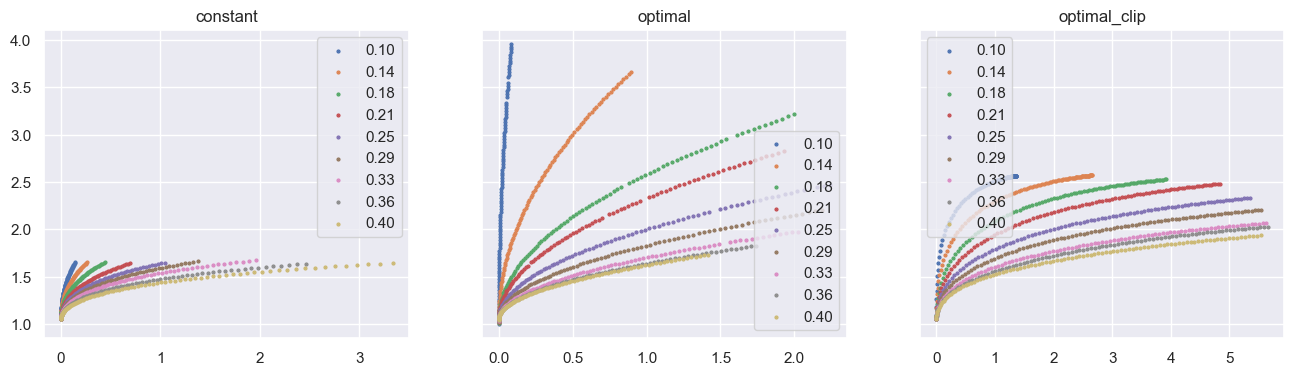

In [10]:
fig, axes = plt.subplots(1,3,figsize = [16,4], sharey=True)
ax_flat = axes.flatten()  # type: ignore
for sigma, strategy_dict in sigma_mean_var_dict.items():
    for i, (strategy_name, mean_var) in enumerate(strategy_dict.items()):
        ax_flat[i].scatter(mean_var['var'], mean_var['mean'], s = 1, marker='o', linestyle='-',linewidth=2, label = f'{sigma:.2f}')
        ax_flat[i].legend()
        ax_flat[i].set_title(strategy_name)